# Multi-Echo fMRI Sequences

In this chapter, we give a high level overview of MRI pulse sequences with the goal of explaining what is involved in how different parameters interact with multi-echo fMRI acqusition.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from myst_nb import glue

In [2]:
# These functions are used to make the simplified pulse sequence visualizations
def plt_sinc(x_start, x_dur):
    """Plot a sinc function that start at time x_start and lasts for x_dur ms."""
    n_vals = 100
    sinc_vals = np.sinc(np.linspace(-4, 4, n_vals))
    sinc_timing = np.linspace(x_start, x_start+x_dur, n_vals)
    plt.plot(sinc_timing, sinc_vals, 'k', linewidth=0.75)

def plt_sin(x_center, x_dur, n_cycles, color):
    """
    Plot a sin wave
    
    Parameters
    ----------
    x_center: The center time for the sin wave in ms
    x_dur: The duration of the sin wave
    n_cycles: The number of cycles in the sin wave
    color: The color of the line for the sin wave
    """
    n_vals = 1000
    sin_vals = np.sin(n_cycles*2*np.pi*np.linspace(0,1,n_vals))/2
    sin_timing = np.linspace(x_center-x_dur/2, x_center+x_dur/2, n_vals)
    plt.plot(sin_timing, sin_vals, color, linewidth=0.75)

    
def create_simple_pulse_seq(tes, read_time=None, x_axis_duration=None, n_acq = 2, n_cycles=16, sinc_dur=2, title=None):
    """
    Create a simple pulse sequence figure with the goal of explaining multi-echo

    Parameters
    ----------
    tes (List): The echo times (TEs) in milliseconds
    read_time: The duration of the read time for each echo (i.e. how long the sinusoids will appear)
        Default is None. For >2 echos, this will calculate read times as
        0.95*(the difference between the first wo echoes)
        Will crash if this is None with only 1 echo
    x_axis_duration: The range of the x axis goes from x to this value.
        Default is None and will be long enough to show the full echo train
        Can be set so that several plots have the same x range and can be compared
    n_acq: The number of sinc pulses followed by sinusoids to include
        Default is 2
    n_cycles: Number of sinusoid cycles to show in each echo train
        Default is 16, which is less than most actual acquisitions,
        but more realistic values make it hard to see the sinusoids compressing with different read_times
    sinc_dur: The shape of the sinc for the excitation pulse is hard coded,
    but it can be made larger or smaller to support visualization
        Default is 2
    title: A text string title for the plot
    
    Returns
    -------
    read_time, x_axis_duration: Same has above, but will be want was calculated within the code
        Useful if running the longest duration pulse sequence first and then using the same
        x_axis_duration for all other plots
    """

    if len(tes) == 1:
        colorlist = ['g']
        #if x_axis_duration == None:
        #    x_axis_duration = n_acq*(tes[0] + read_time/2) + 7
    else:
        colorlist = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
        if read_time == None:
            read_time = 0.95*(tes[1]-tes[0])
        if x_axis_duration == None:
            x_axis_duration = n_acq*(tes[-1] + read_time/2) + 7

    excite_start = 0
    for acq_iter in range(n_acq):
        plt_sinc(excite_start, sinc_dur)
        for echo_idx, echo_val in enumerate(tes):
            plt_sin(excite_start+echo_val, read_time, n_cycles, colorlist[echo_idx])
            plt.plot(excite_start+np.linspace(sinc_dur/2, echo_val, 20), np.tile(0.52+echo_idx*0.1, 20), 'k', linestyle='--')
            plt.text(excite_start+(echo_val - sinc_dur/2)/2, 0.53+0.1*echo_idx, f"TE {echo_idx+1}")
        excite_start = excite_start + echo_val + read_time/2 + 0.5
        if acq_iter == 0:
            plt.plot([0, excite_start], [1, 1], 'k', linestyle='-.')
            plt.text(excite_start*0.45, 1.01, "1 acquisition cycle")

    plt.xlim(0,x_axis_duration)
    plt.xlabel('Time (ms)')
    if title:
        plt.title(title)

    return read_time, x_axis_duration

## A simplified fMRI pulse sequence

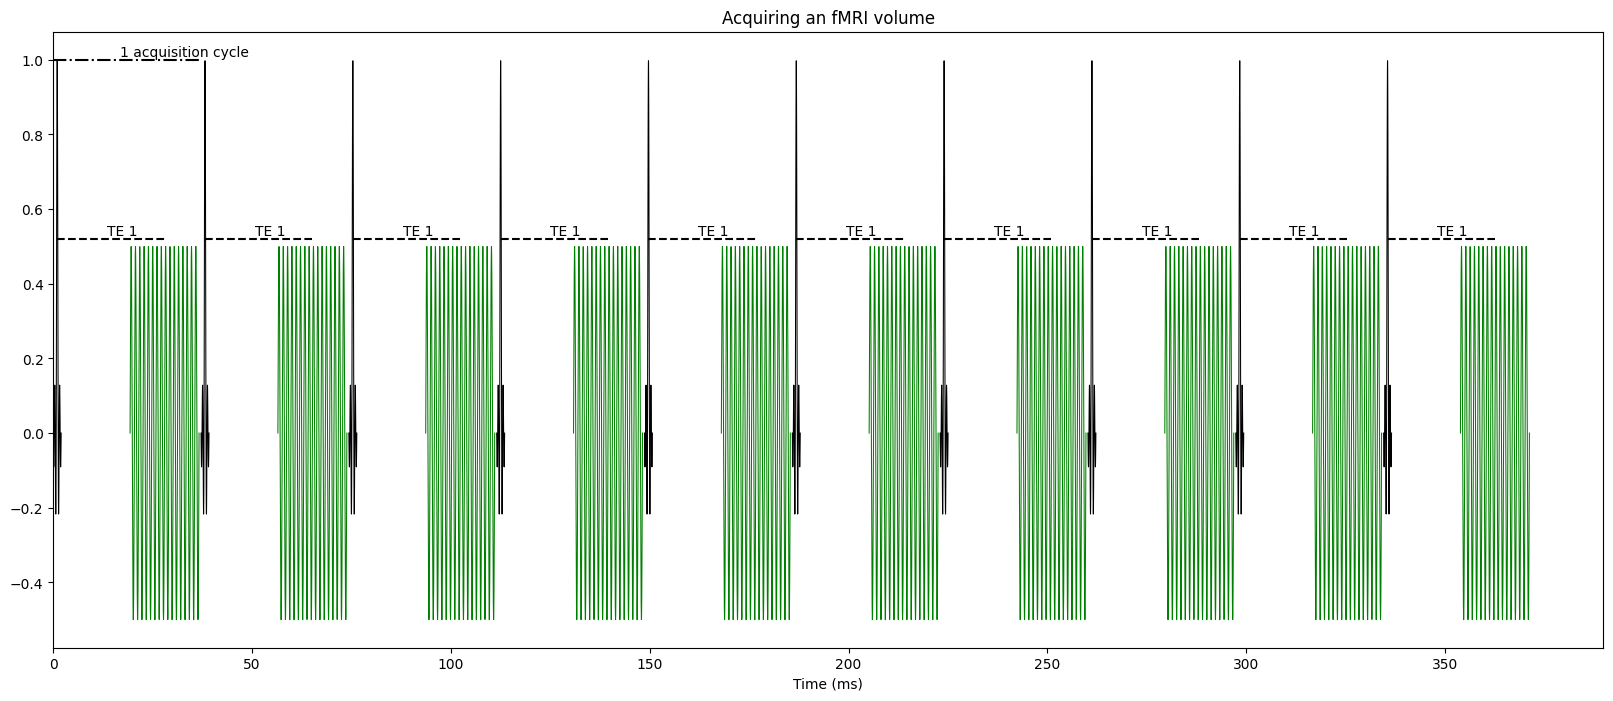

In [3]:
fig = plt.figure(figsize=(20,8))
create_simple_pulse_seq([28], read_time=17.347, n_acq=10, title="Acquiring an fMRI volume")
glue("fig_sample_pulse_seq", fig, display=False)

```{glue:figure} fig_sample_pulse_seq
:name: fig_sample_pulse_seq
:align: center

A simplified fMRI pulse sequence.
```

For the purposes of understanding multi-echo fMRI,
an fMRI pulse sequence has two main parts.
The excitation pulse (black) and the readout (green).
The excitation pulse sends out a radio frequency pulse that excites protons at a resonance frequency
(The "resonance" part of Magnetic Resonance Imaging).
The readout period (green) is when the gradient magnets oscillate
to acquire data across a portion of k-space.
In a typical fMRI study, each excitation pulse excites protons in
one slice or several slices of the brain,
and then the readout period collects data from those slice(s).
Multiple excitation pulses and readout windows are necessary to collect a full volume.
In this figure, there are 10 excitation pulses.
If 4 slices were collected with each excitation pulse
(called simultaneous multislice, multiband, or hyperband imaging),
this figure represents acquiring 40 slices.
In this example, each excitation + readout cycle takes around 37ms,
and the time to aquire a 40 slice volume would be 370ms.

Note that there is a gap between the excitation pulse and the readout window.
This gap is called the echo time (TE).
That gap is not due to hardware constraints.
It is because the Blood Oxygen Level Dependent (BOLD) signal
that is central to most fMRI studies is largest with a specfic delay.
There is more information about the link between BOLD contrast
and TE in the following sections.
For example, for a 3T MRI, the BOLD contrast is largest at approximately 28ms.

Also note that the readout period is not instantaneous.
It takes time to have the magnetic gradients to move around in ways that collect the desired information across k-space.
The TE is the center of this readout period.
In this figure, the TE is 28ms, but data is acquire during the readout period from around 19-36ms.

## A multi-echo fMRI pulse sequence

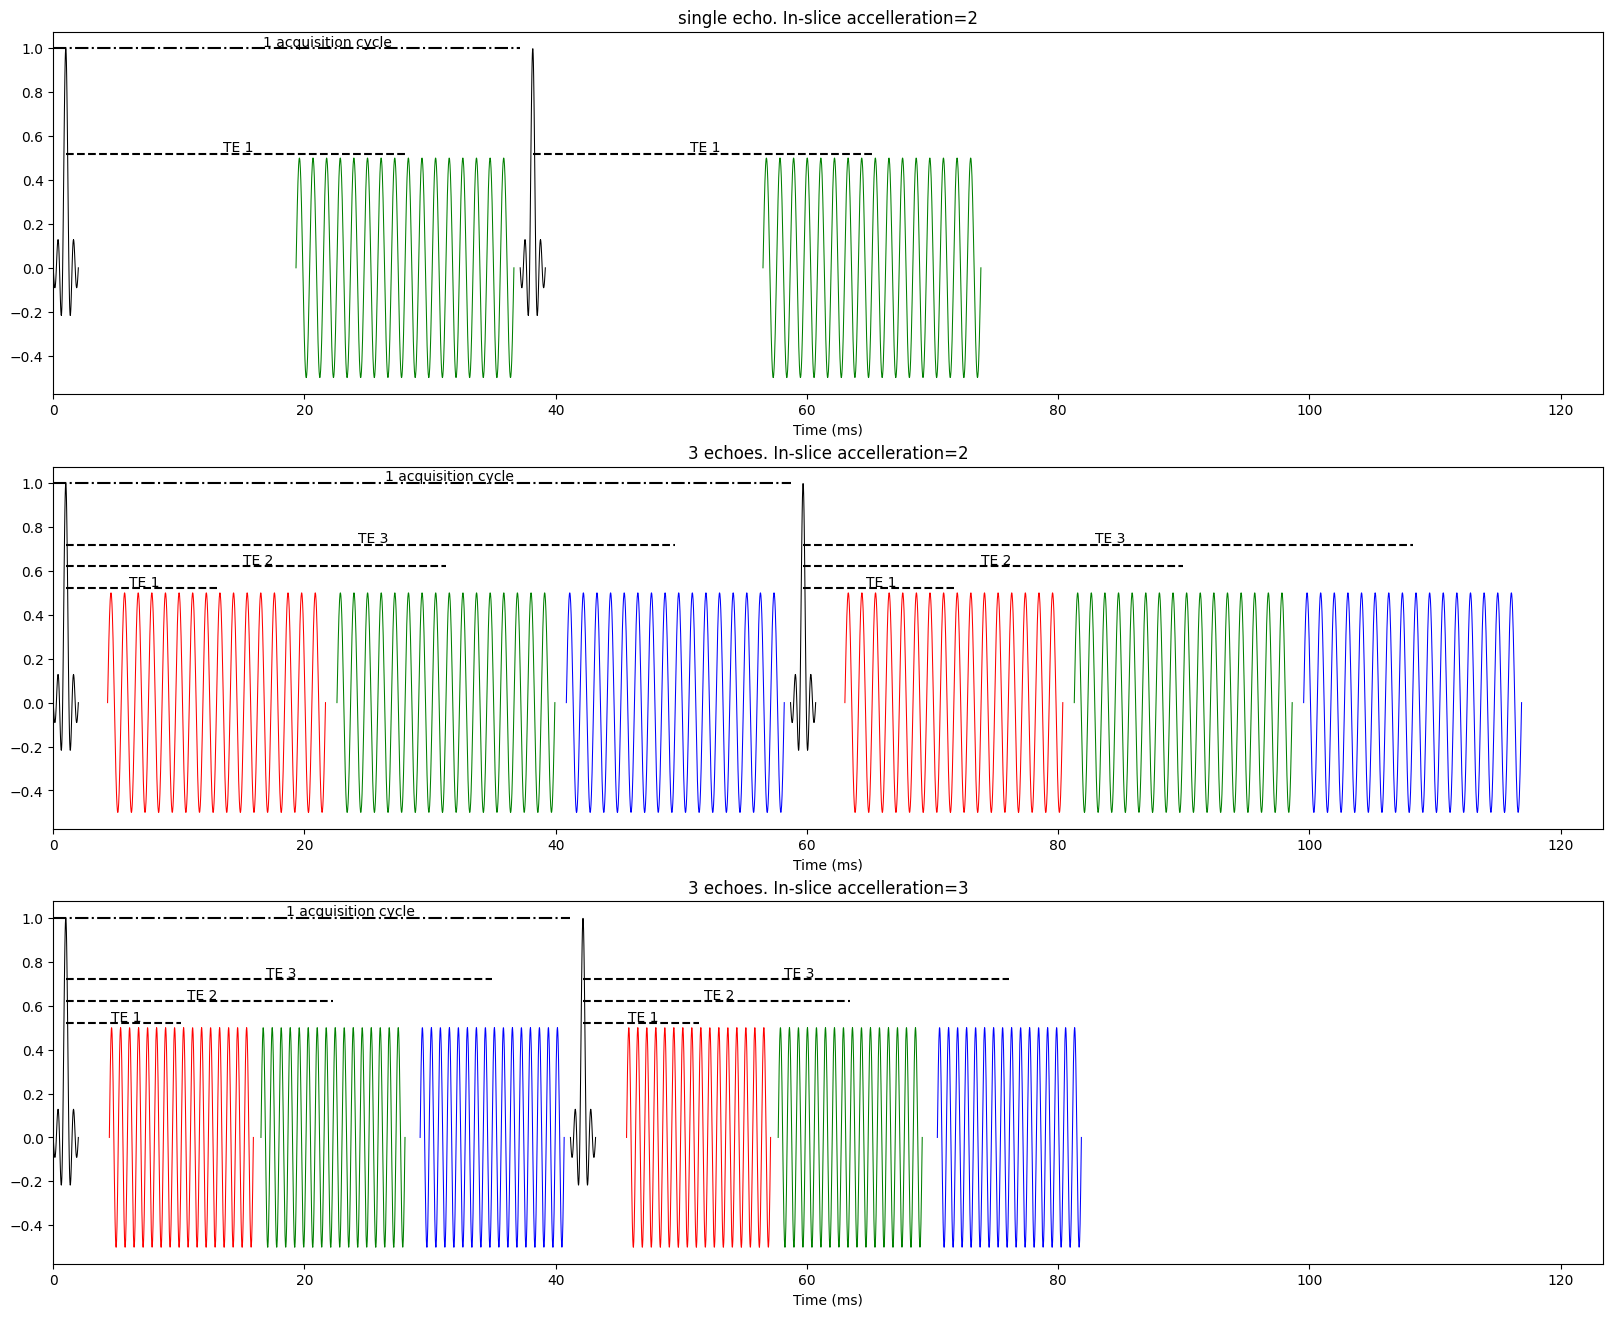

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(20,16))

plt.subplot(3,1,2)
read_time, x_axis_duration = create_simple_pulse_seq([13, 31.26, 49.52], title="3 echoes. In-slice accelleration=2")

plt.subplot(3,1,1)
create_simple_pulse_seq([28], read_time=read_time, x_axis_duration=x_axis_duration, title="single echo. In-slice accelleration=2")

plt.subplot(3,1,3)
create_simple_pulse_seq([10.2, 22.27, 34.94], x_axis_duration=x_axis_duration, title="3 echoes. In-slice accelleration=3")

glue("fig_sample_multiecho_pulse_seq", fig, display=False)

```{glue:figure} fig_sample_multiecho_pulse_seq
:name: fig_sample_multiecho_pulse_seq
:align: center

A sample multi-echo fMRI pulse sequence.
```

The top plot in the above figure shows two cycles of single echo acquisition.
The middle figure shows the same readout duration, but with 3 acquired echoes.
Instead of the gap between the excitation pulse and a single echo,
the same readout pattern is repeated 3 time as quickly as possible.
This results in data to create 3 images from every excitation pulse.
The key benefit of this is,
instead of having a single echo at what is expected to be the optimal TE for BOLD constrast,
there are multiple echoes that can be fit to a model of how BOLD constrast is expected to evolve over time.

Note that the first echo can often fit mostly within the intial gap and is essentially free.
There are some methods and use and benefit from just 2 echoes {cite:t}`bright2013removing`.

The third echo noticabily expands the time between two excitation pulses.
This means, if no other parameters change, the TR will be longer to acquire 3 echoes vs single echo data
and even longer if more than 3 echoes are acquired.

Acquiring multi-echo fMRI data typcially requires mild compromises on other parameters.
This can include a mix of:

- Longer TR
- Fewer slices
- Larger voxels: shorter readout time
- More in-slice accelleration (sometimes called GRAPPA, iPat, or ASSET): shorter readout time

The bottom figure above has identical parameters, but uses GRAPPA=3 inslice acceleration instead of GRAPPA=2.
With just this change, the readout time for each echo has a shorter duration
and the TR is nearly identical to the single echo example.
Continuing on this example, in-slice acceleration has a cost.
The Signal to Noise Ratio (SNR) for fMRI data drops roughly by the square root of the acceleration factor.
That is GRAPPA=2 has an SNR reduction of roughly $\sqrt{2}$.
That means going from GRAPPA=2 to GRAPPA=3 has an SNR reduction of $\sqrt{3}-\sqrt{2}$.

Collecting 3 echoes and just averaging them together gives an SNR increase that is close to $\sqrt{3}$ is this is a net positive even without any fancier multi-echo denoising approaches.
More acceleration and faster readouts also means all the data is acquired closer to the desired echo time,
and a faster readout often means less distortion.
That said, more acceleration can also results in more MRI artifacts,
so it is critial to collect data to evaluate parameters before collecting data for a full study.

One additional consideration is why the readout windows are the length they are.
This is partially the limits of the MRI hardware.
The readout gradients are rapidly changing magnetic fields using electromagnets.
There are limits to how fast a given system can alter electric currents to drive these magnetic field changes without overheating.
A second key factor is that a rapidly changing magnetic field surrounding a conductive material can generate electric current in that material.
People are conductive materials.
This is why people sometimes experience
[peripheral nerve stimulation (PNS)](https://mriquestions.com/nerve-stimulation.html)
in MRI machines.
Modern MRI hardware is capable of driving faster magnetic field changes,
but they have build-in safety controls that limit on how fast the graidents can change to prevent dangerous levesl of PNS.
Innovations in how to span k-space with slower changes in gradient fields
and magnetic gradient hardware that only spans the head,
rather than the entire scanner bore,
are some ways MRI physicists are working to shorten readout times.


More information on what to consider when setting multi-echo fMRI parameters is in the [Practical Resources: Acquiring Multi-Echo Data](./Acquiring_Multi_Echo_Data.html) section.